# Topog form stress using MOM025 DATA

Recent update 26 Aug 2017

In [27]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

# Topographic Stress term comparing


# $$F_{topog} = \int_x  P_{bot}*dH$$
## 1. define new_dH    $new\_dH_{n+1} = (new\_d_{n+2}-new\_d_{n})/2$, where new_d=depth with NAN set to 0. 
## 2. define new_pbot = pbot with NAN set to 0.
## 3. define new_pb, $new\_pb(n+1)=new\_pbot(n+2)+new\_pbot(n)$

In [28]:
## Load data

%time
OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
depth = dsx1.ht   ## H
dxu = dsx1.dxu ## dxu

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
pbot = dsx2.pbot_t.mean('time')     ## p_bot

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')
rho = dsx3.rho.mean('time')        ## \rho
dz = dsx3.dzt.mean('time')      ## dzt
g = 9.8196
rho0=1035


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [29]:
## 1. set a new depth 'new_d' change NAN to 0
new_d = np.zeros(depth.shape)
new_d = depth.values
new_d[np.isnan(new_d)]=0

## new_dH using new_d, new_dH(n+1)=new_d(n+2)-new_d(n)
new_dH = np.zeros(depth.shape)
new_dH[:,1:-1] = 0.5*(new_d[:,2:] - new_d[:,:-2])
new_dH[:,0] = 0.5*(new_d[:,1]- new_d[:,-1])
new_dH[:,-1] = 0.5*(new_d[:,0]- new_d[:,-2])

(-70, -30)

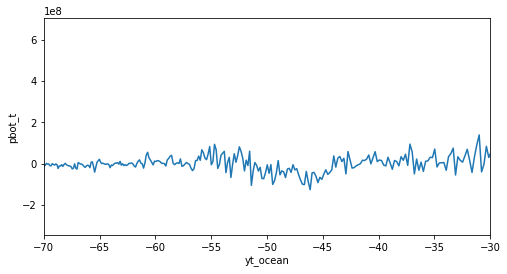

In [30]:
## 1. plot \int_x pbot*new_dH ~ 10^8, shape is better than before too.
plt.figure(figsize=(8,4))
tmp1 = 10000*pbot*new_dH
tmp1.sum('xt_ocean').plot()
plt.xlim([-70,-30])

(180, 360)

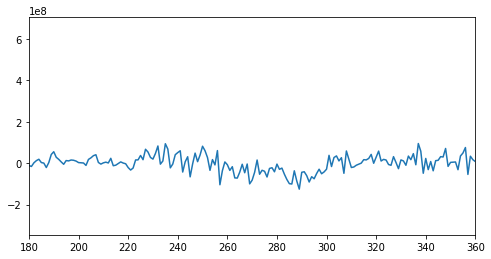

In [31]:
## 2. set a new pbot 'new_pbot' change NAN to 0
## plot \int_x new_pbot*new_dH, has some small change to the shape
## yt_ocean (-70,-30) is same as (180,360)
new_pbot = np.zeros(pbot.shape)
new_pbot = pbot.values
new_pbot[np.isnan(new_pbot)]=0

plt.figure(figsize=(8,4))
tmp2 = 10000*new_pbot*new_dH
plt.plot(np.sum(tmp2,axis=1))
plt.xlim([180,360])

(180, 360)

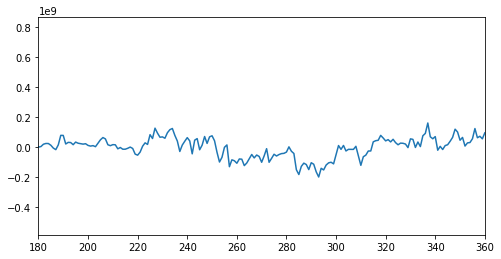

In [32]:
##3. set a new_pb, new_pb(n+1)=(new_pbot(n+2)+new_pbot(n))/2
## plot \int_x new_pb*new_dH, magnitude increases by 10 times. Why?

new_pb = np.zeros(pbot.shape)
new_pb[:,1:-1] = 0.5*(new_pbot[:,2:] + new_pbot[:,:-2])
new_pb[:,0] = 0.5*(new_pbot[:,1]+ new_pbot[:,-1])
new_pb[:,-1] = 0.5*(new_pbot[:,0]+ new_pbot[:,-2])

plt.figure(figsize=(8,4))
tmp3 = 10000*new_pb*new_dH
plt.plot(np.sum(tmp3,axis=1))
plt.xlim([180,360])

## Conclusion and Questions:
## 1. Use new_dH, form stress term ~ 10^8, much smaller than simply using ddepth=depth.diff (form stress ~10^12)
## 2. By setting 'NAN' value in Pbot to 0, form stress term still~ 10^8, with small changes to the fluctuations
## 3. By averaging Pbot, form stress term becomes larger, does it mean the form stress is very sensitive to Pbot ( H*dH seems not so sensitive)??? Maybe need to consider partial cell or something else???